In [3]:
# IMPORTS
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import pickle
import pandas_datareader as webreader
import datetime as dt
from math import sqrt
import datetime


import tensorflow.keras as keras
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras import optimizers
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from datetime import date, timedelta, datetime
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from tensorflow.python.client import device_lib
from sklearn import metrics
from sklearn.svm import SVC

from sklearn import svm

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12416992576208438958,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1375462196
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12902661452826130842
 physical_device_desc: "device: 0, name: NVIDIA GeForce MX150, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [4]:
# COMMON
symbol = 'AAPL'
stockname = 'AAPL'
timeWindowInYears = 5
timeWindowInDays = timeWindowInYears * 365
testDays = 100
FEATURES = ['Close','High','Low', 'Open', 'Adj Close']
# FEATURES = ['Close']

In [5]:
# PULL DATASET FROM YAHOO FINANCIALS
today = datetime(2022, 2, 27)
date_today = today.strftime("%Y-%m-%d")
date_start = pd.Timestamp('2022-02-27') - timedelta(days=timeWindowInDays)
print(date_today)
df = webreader.DataReader(symbol, data_source='yahoo', start=date_start, end=date_today)
df.tail()

2022-02-27


High         Low        Open       Close       Volume  \
Date                                                                      
2022-02-18  170.539993  166.190002  169.820007  167.300003   82772700.0   
2022-02-22  166.690002  162.149994  164.979996  164.320007   91162800.0   
2022-02-23  166.149994  159.750000  165.539993  160.070007   90009200.0   
2022-02-24  162.850006  152.000000  152.580002  162.740005  141147500.0   
2022-02-25  165.119995  160.869995  163.839996  164.850006   91974200.0   

             Adj Close  
Date                    
2022-02-18  167.300003  
2022-02-22  164.320007  
2022-02-23  160.070007  
2022-02-24  162.740005  
2022-02-25  164.850006

In [6]:
# calculate correlation
df.corr()['Close']

High         0.999748
Low          0.999739
Open         0.999495
Close        1.000000
Volume      -0.167750
Adj Close    0.999977
Name: Close, dtype: float64

In [7]:
# select relevant features
# Extracting the series
dfWithRelevantFeatures = df[FEATURES] # Picking the series with high correlation
print(dfWithRelevantFeatures.tail())

                 Close        High         Low        Open   Adj Close
Date                                                                  
2022-02-18  167.300003  170.539993  166.190002  169.820007  167.300003
2022-02-22  164.320007  166.690002  162.149994  164.979996  164.320007
2022-02-23  160.070007  166.149994  159.750000  165.539993  160.070007
2022-02-24  162.740005  162.850006  152.000000  152.580002  162.740005
2022-02-25  164.850006  165.119995  160.869995  163.839996  164.850006


In [8]:
train_data, test_data = np.split(dfWithRelevantFeatures, [int(.8 *len(dfWithRelevantFeatures))])
print(train_data.shape,test_data.shape)

(1007, 5) (252, 5)


In [80]:
x_train = train_data.iloc[:, 0:5].values
y_train = train_data.iloc[:, 0].values
x_test = test_data.iloc[:, 0:5].values
y_test = test_data.iloc[:, 0].values
print(y_test)

[ 34.94749832  34.74000168  34.94499969 ... 160.07000732 162.74000549
 164.8500061 ]


IndexError: index 5 is out of bounds for axis 0 with size 5

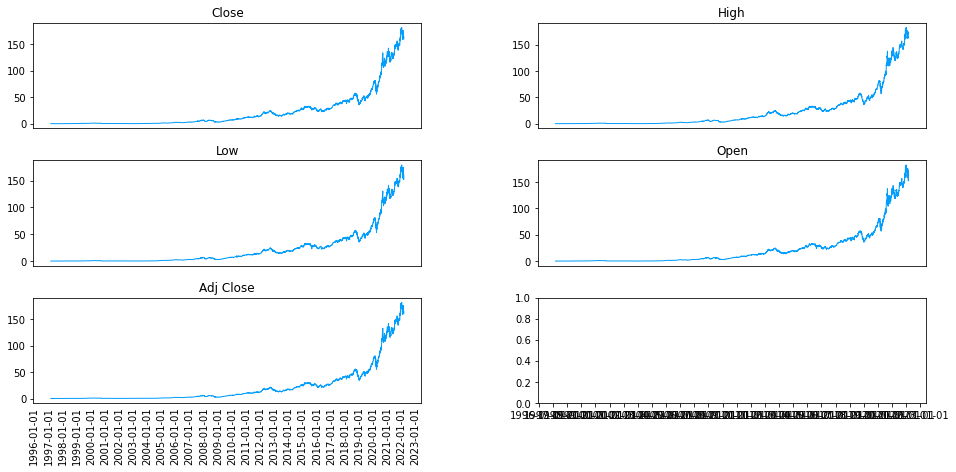

In [81]:
# Plot each column
register_matplotlib_converters()
nrows = 3
ncols = int(round(dfWithRelevantFeatures.shape[1] / nrows, 0))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(16, 7))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
x = dfWithRelevantFeatures.index
columns = dfWithRelevantFeatures.columns
f = 0
for i in range(nrows):
    for j in range(ncols):
        ax[i, j].xaxis.set_major_locator(mdates.YearLocator())
        assetname = columns[f]
        y = dfWithRelevantFeatures[assetname]
        f += 1
        ax[i, j].plot(x, y, color='#039dfc', label=stockname, linewidth=1.0)
        ax[i, j].set_title(assetname)
        ax[i, j].tick_params(axis="x", rotation=90, labelsize=10, length=0)  

In [82]:
"""
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.fit_transform(val_data)
test = sc.fit_transform(test_data)
print(train.shape,val.shape,test.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(dfWithRelevantFeatures['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)
"""
scale = StandardScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

In [85]:
model = svm.SVR(kernel ='rbf',C=1.00)
model.fit(x_train, y_train)
predict = model.predict(x_test)
print(predict)
print(predict.shape)

[33.47763517 33.43666117 33.47197998 ... 16.34656634 16.34656634
 16.34656634]
(1258,)


In [67]:
model = RandomForestRegressor(n_estimators=500, random_state=42, min_samples_split=2, min_samples_leaf=1, max_depth=10, bootstrap=True)
model.fit(x_train, y_train)
predict = model.predict(x_test)
print(predict)
print(predict.shape)
print(y_test)



[34.24692508 34.24692508 34.24692508 ... 34.24692508 34.24692508
 34.24692508]
(1258,)
[ 34.94749832  34.74000168  34.94499969 ... 160.07000732 162.74000549
 164.8500061 ]


In [86]:
predictions_unscaled = predict
true_unscaled = y_test

diff = predictions_unscaled - true_unscaled
percent_diff = (abs(predictions_unscaled - true_unscaled) / true_unscaled) * 100.0
abs_diff = abs(diff)
valid = pd.DataFrame()
valid['Difference'] = diff.flatten()
valid['Abs_Difference'] = abs_diff.flatten()
valid['Percent_Difference'] = percent_diff.flatten()
print(valid)
print("abs diff mean: ", valid['Abs_Difference'].mean())
print("abs diff median: ", valid['Abs_Difference'].median())
print("percent diff mean: ", valid['Percent_Difference'].mean())
print("percent diff median: ", valid['Percent_Difference'].median())
print(valid.describe())

      Difference  Abs_Difference  Percent_Difference
0      -1.469863        1.469863            4.205918
1      -1.303341        1.303341            3.751700
2      -1.473020        1.473020            4.215252
3      -1.382282        1.382282            3.968084
4      -1.415535        1.415535            4.058301
...          ...             ...                 ...
1253 -150.953437      150.953437           90.229189
1254 -147.973441      147.973441           90.051993
1255 -143.723441      143.723441           89.787864
1256 -146.393439      146.393439           89.955410
1257 -148.503440      148.503440           90.083976

[1258 rows x 3 columns]
abs diff mean:  58.57263229842494
abs diff median:  39.02052469675195
percent diff mean:  63.044578916788666
percent diff median:  70.24238848088709
        Difference  Abs_Difference  Percent_Difference
count  1258.000000     1258.000000         1258.000000
mean    -58.572632       58.572632           63.044579
std      46.911041       

In [115]:

# OR load the model
model = load_model("GRU_GPU_AAPL_25Y_noTA.h5")


In [87]:
ind = np.arange(len(valid))
                        
plt.rcParams["figure.figsize"] = (22,10)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30)) 
plt.plot(true_unscaled,c = 'r')
plt.plot(predictions_unscaled,c = 'b')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('The IBEX 35 Prediction Graph using Multivariate-GRU model')
plt.legend(['Actual','Predicted'],loc = 'lower right')

y = valid["Difference"]
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"
plt.bar(ind, y, width=0.8, color=valid['diff_color'])

plt.show()

In [172]:
# save the model to disk
model.save("GRU_GPU_IBEX_5Y_noTA.h5")

In [93]:
print(pred)

NameError: name 'pred' is not defined

In [56]:
# BACKTESTING feature
# THIS IS ALL-IN STRATEGY - BUY AND SELL WITH THE MAXIMUM AMOUNT OF MONEY AVAILABLE
CADENCES = [1,3,7]
for CADENCE in CADENCES:
    money = 1000
    correct = 0
    total = 0
    for i in range (0, len(predictions_unscaled), CADENCE):
        #print(i)
        if i > 0:
            total = total + 1
            todays_pred = float(predictions_unscaled[i])
            yesterdays_pred = float(predictions_unscaled[i-CADENCE])
            todays_price = float(true_unscaled[i])
            yesterdays_price = float(true_unscaled[i-CADENCE])
            percent_diff = (abs(todays_price - yesterdays_price) / yesterdays_price) * 100.0
            #print(percent_diff)
            if todays_pred > yesterdays_pred:
                #print("Predicting price rise. Current pred: ", yesterdays_pred, "predicted price: ", todays_pred)
                if todays_price > yesterdays_price:
                    #print("Prediction was correct! Price was rising", yesterdays_price, " -> ", todays_price)
                    money = money + (money * (percent_diff / 100))
                    #print("Current amount: ", money)
                    #print("\n")
                    correct = correct + 1

                else:
                    #print("Prediction was wrong...", yesterdays_price, " -> ", todays_price)
                    money = money - (money * (percent_diff / 100))
                    #print("Current amount: ", money)
                    #print("\n")


            else:
                #print("Predicting price fall. Current pred: ", yesterdays_pred, "predicted price: ", todays_pred)
                if todays_price < yesterdays_price:
                    #print("Prediction was correct! Price was falling", yesterdays_price, " -> ", todays_price)
                    money = money + (money * (percent_diff / 100))
                    #print("Current amount: ", money)
                    #print("\n")
                    correct = correct + 1
                else:
                    #print("Prediction was wrong...", yesterdays_price, " -> ", todays_price)
                    money = money - (money * (percent_diff / 100))
                    #print("Current amount: ", money)
                    #print("\n")
    print("CADENCE: ", CADENCE)
    print("Correct: ", correct, " and total: ", total)
    print("Final amount: ", money)
    print("Total model accuracy: ", correct/total*100, "%")
    print("\n")

CADENCE:  1
Correct:  176  and total:  251
Final amount:  3221.057542691975
Total model accuracy:  70.1195219123506 %


CADENCE:  3
Correct:  60  and total:  83
Final amount:  1886.177906753289
Total model accuracy:  72.28915662650603 %


CADENCE:  7
Correct:  20  and total:  35
Final amount:  1309.2076370360028
Total model accuracy:  57.14285714285714 %




In [57]:
# BACKTESTING feature
# THIS IS ALL-IN STRATEGY - BUY AND SELL WITH THE MAXIMUM AMOUNT OF MONEY AVAILABLE
CADENCES = [1,3,7]
for CADENCE in CADENCES:
    money = 1000
    correct = 0
    total = 0
    for i in range (0, len(predictions_unscaled)):
        #print(i)
        if i > CADENCE - 1:
            total = total + 1
            todays_pred = float(predictions_unscaled[i])
            yesterdays_pred = float(predictions_unscaled[i-CADENCE])
            todays_price = float(true_unscaled[i])
            yesterdays_price = float(true_unscaled[i-CADENCE])
            percent_diff = (abs(todays_price - yesterdays_price) / yesterdays_price) * 100.0
            #print(percent_diff)
            if todays_pred > yesterdays_pred:
                #print("Predicting price rise. Current pred: ", yesterdays_pred, "predicted price: ", todays_pred)
                if todays_price > yesterdays_price:
                    #print("Prediction was correct! Price was rising", yesterdays_price, " -> ", todays_price)
                    money = money + (money * (percent_diff / 100))
                    #print("Current amount: ", money)
                    #print("\n")
                    correct = correct + 1

                else:
                    #print("Prediction was wrong...", yesterdays_price, " -> ", todays_price)
                    money = money - (money * (percent_diff / 100))
                    #print("Current amount: ", money)
                    #print("\n")


            else:
                #print("Predicting price fall. Current pred: ", yesterdays_pred, "predicted price: ", todays_pred)
                if todays_price < yesterdays_price:
                    #print("Prediction was correct! Price was falling", yesterdays_price, " -> ", todays_price)
                    money = money + (money * (percent_diff / 100))
                    #print("Current amount: ", money)
                    #print("\n")
                    correct = correct + 1
                else:
                    #print("Prediction was wrong...", yesterdays_price, " -> ", todays_price)
                    money = money - (money * (percent_diff / 100))
                    #print("Current amount: ", money)
                    #print("\n")
    print("CADENCE: ", CADENCE)
    print("Correct: ", correct, " and total: ", total)
    print("Final amount: ", money)
    print("Total model accuracy: ", correct/total*100, "%")
    print("\n")

CADENCE:  1
Correct:  176  and total:  251
Final amount:  3221.057542691975
Total model accuracy:  70.1195219123506 %


CADENCE:  3
Correct:  178  and total:  249
Final amount:  6640.595536315736
Total model accuracy:  71.4859437751004 %


CADENCE:  7
Correct:  164  and total:  245
Final amount:  10297.66322495322
Total model accuracy:  66.93877551020408 %




0
1


NameError: name 'total3' is not defined